In [1]:
# boilerplate code
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf


model_fn = '../tmp/inception5h/tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

layers = [op.name for op in graph.get_operations() if op.type == 'Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name + ':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))


# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add()
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>" % size)
    return strip_def


def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add()
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0] != '^' else '^' + rename_func(s[1:])
    return res_def

Number of layers 59
Total number of feature channels: 7548


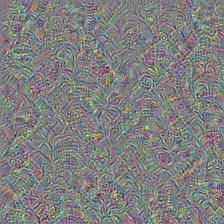

In [8]:
# Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity
# to have non-zero gradients for features with negative initial activations.
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 10  # picking some feature channel to visualize

# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224, 224, 3)) + 100.0


def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1) * 255)
    f = BytesIO()
    #f = "deepdream_log/img_%s.%s" % (int(time.time()), fmt)
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))


def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a - a.mean()) / max(a.std(), 1e-4) * s + 0.5


def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0" % layer)


def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj)  # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0]  # behold the power of automatic differentiation!

    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input: img})
        # normalizing the gradient, so the same step size should work
        g /= g.std() + 1e-8  # for different layers and networks
        img += g * step
        print(score)
    clear_output()
    showarray(visstd(img))

render_naive(T(layer)[:, :, :, channel])